![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

# TFM - Modelo Baseline de Regresión



# **_1. Librerías y configuración_**

In [16]:
# Principales

import pandas as pd
import numpy as np
# # Modificaciones
# import re
# import unicodedata
# import datetime
# import os
# import math

# visuzalizaciones
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.figure_factory as ff

from sklearn import metrics
from sklearn.model_selection import train_test_split # Import train_test_split
from sklearn.model_selection import RandomizedSearchCV # Import RandomizedSearchCV

# Import library for Linear Regression
from sklearn.linear_model import  Ridge, Lasso  # Import Ridge and Lasso

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from xgboost import XGBRegressor

import gc

In [17]:
# Forzar la recolección de basura
gc.collect()

474

In [18]:
pd.set_option('display.max_info_columns',110 )
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows',80)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', None)
# Ajustar la configuración para mostrar más filas
# pd.set_option('display.max_rows', 500)

# Inicializar la lista to replace
to_replace=['Null','Nan','nan','NULL',None]

# **_2. Funciones_**

In [19]:
#Funcion que agrupa las columnas por tipo de dato

def columnas_por_tipo(df):
    # Filtrar columnas por tipo de datos
    int_columns = [col for col in df.columns if df[col].dtype.name.startswith('int')]
    float_columns = [col for col in df.columns if df[col].dtype.name.startswith('float')]
    boolean_columns=[col for col in df.columns if set(df[col].unique()) <= {0, 1}]
    numeric_cols=int_columns + float_columns
    object_columns = df.select_dtypes(include='object').columns.tolist()
    category_columns = df.select_dtypes(include='category').columns.tolist()

    cat_columns=list(set(category_columns) - set(boolean_columns) )
    # Obtener todas las columnas
    all_columns = set(df.columns)
    # # Columnas de otros tipos
    other_columns = list(all_columns - set(int_columns) - set(float_columns) - set(object_columns) - set(category_columns))

    # Cuento el número de columnas de cada tipo
    num_int_columns = len(int_columns)
    num_float_columns = len(float_columns)
    num_object_columns = len(object_columns)
    num_category_columns = len(category_columns)
    num_other_columns = len(other_columns)

    # Mostrar los resultados
    print("Número de columnas de tipo entero:", num_int_columns)
    print("Columnas de tipo entero:", int_columns)
    print("Número de columnas de tipo float:", num_float_columns)
    print("Columnas de tipo float:", float_columns)
    print("Número de columnas de tipo object:", num_object_columns)
    print("Columnas de tipo object:", object_columns)
    print("Número de columnas de tipo category:", num_category_columns)
    print("Columnas de tipo category:", category_columns)
    print("Número de columnas de otros tipos:", num_other_columns)
    print("Columnas de otros tipos:", other_columns)
    return boolean_columns,numeric_cols,cat_columns,object_columns,other_columns

In [20]:

def reduce_mem_usage(df, turn_cat=False, silence=True):
    """Itera sobre todo el dataset convirtiendo cada columna en el tipo más adecuado para ahorrar memoria.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe que se quiere reducir.
    turn_cat : bool, optional
        Transformación de las columnas objeto o string a category, by default False.

    Returns
    -------
    pd.DataFrame
        Dataframe optimizado.
    """

    start_mem = df.memory_usage().sum() / 1024**2  # Memoria inicial

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and not isinstance(col_type, pd.CategoricalDtype):
            c_min = df[col].min()
            c_max = df[col].max()

            if pd.api.types.is_numeric_dtype(df[col]):
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)

                # Conversión de float a int si no hay decimales y no hay NaN
                df[col] = df[col].fillna(0)  # Rellenar NaN antes de verificar si son enteros
                if all(df[col].apply(float.is_integer)):
                    df[col] = df[col].astype(np.int64)

        # Conversión de objetos a categoría si turn_cat es True
        if turn_cat and col_type == object:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # Memoria final

    if not silence:
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


# **_3. Carga de datos_**

In [21]:
df= pd.read_csv('./data/dfbaseline_sin_process.csv',index_col=False)
#dfb= pd.read_csv('./dfEDA_final.csv',index_col=False)

C:\Users\extas\AppData\Local\Temp\ipykernel_14360\1562035174.py:1: DtypeWarning:

Columns (10,16,21,39) have mixed types. Specify dtype option on import or set low_memory=False.



In [22]:
df.shape

(10032, 109)

In [23]:
df = dfb.loc[:, ~dfb.columns.duplicated()]


In [24]:
column_name = dfb.columns[94]

print(f"El nombre de la columna  45 es: {column_name}")

El nombre de la columna  45 es: hog_con_7


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10032 entries, 0 to 10031
Data columns (total 109 columns):
 #    Column                                            Non-Null Count  Dtype  
---   ------                                            --------------  -----  
 0    Unnamed: 0                                        10032 non-null  int64  
 1    url                                               10032 non-null  object 
 2    m2_constr                                         10032 non-null  float64
 3    distrito                                          10032 non-null  object 
 4    cod_distrito                                      10032 non-null  int64  
 5    barrio                                            10032 non-null  object 
 6    cod_barrio                                        10032 non-null  int64  
 7    letra_ce                                          2150 non-null   object 
 8    tipologia                                         10032 non-null  object 
 9    esta

La columna precio es de tipo int64, la transformamos a float64, ya que el precio de venta de las viviendas es la variable objetivo en nuestro análisis y el tipo de dato float64 es adecuado para manejar valores de precio con precisión decimal.

In [28]:

df["precio"] = df["precio"].astype("float64")


Vamos a generar una variable  mediante la agrupación de códigos de barrio, calculando el precio promedio por barrio y se clasificaron los codigo de barrio en cinco grupos distintos en función de sus precios promedio relativos.
Nos basamos en la premisa de que las viviendas ubicadas en áreas geográficas similares tienden a tener precios similares.

In [ ]:
# Calcular el precio promedio por barrio
codbarrio_precios = df.groupby('cod_barrio')['precio'].mean().reset_index()

# Clasificar los codigos de barrio en cinco grupos
codbarrio_precios['cod_barrio_group'] = pd.qcut(codbarrio_precios['precio'], q=5, labels=[1, 2, 3, 4, 5])

# Crear un diccionario de mapeo para asignar grupos a cada barrio en el DataFrame original
cod_barrio_mapping = dict(zip(codbarrio_precios['cod_barrio'], codbarrio_precios['cod_barrio_group']))
df['cod_barrio_group'] = df['cod_barrio'].map(cod_barrio_mapping)

#eliminamos la variable 
columns_to_drop = ["cod_barrio"]
df = df.drop(columns=columns_to_drop)

In [35]:

# Contar viviendas por grupo
cod_barrio_group_counts = df["cod_barrio_group"].value_counts(dropna=False).sort_index()

# Descripciones de los grupos
descriptions = {
    1: "las mas baratas entre todas las categorías.",
    2: "precios moderadamente bajos en relación con los demás grupos.",
    3: "un rango de precios similar a las del Grupo 4.",
    4: "más costosas que las del Grupo 2, pero aún no están entre las más caras.",
    5: "las viviendas más caras en el conjunto de datos."
}

# Generar automáticamente el texto
for group, count in cod_barrio_group_counts.items():
    print(f"Grupo {group}: Este grupo contiene {count} viviendas. Estas viviendas son {descriptions.get(group, 'una descripción no especificada.')}")


Grupo 1: Este grupo contiene 1618 viviendas. Estas viviendas son las mas baratas entre todas las categorías.
Grupo 2: Este grupo contiene 1213 viviendas. Estas viviendas son precios moderadamente bajos en relación con los demás grupos.
Grupo 3: Este grupo contiene 1333 viviendas. Estas viviendas son un rango de precios similar a las del Grupo 4.
Grupo 4: Este grupo contiene 2212 viviendas. Estas viviendas son más costosas que las del Grupo 2, pero aún no están entre las más caras.
Grupo 5: Este grupo contiene 3656 viviendas. Estas viviendas son las viviendas más caras en el conjunto de datos.


In [30]:
df.sample(10)

,Unnamed: 0,url,m2_constr,distrito,cod_distrito,barrio,cod_barrio,letra_ce,tipologia,estado,amueblado,planta,dormitorios,banos,balcon,terraza,garaje,trastero,ascensor,antiguedad,num_plantas,jardin,inmueble_ingresos,alquiler_opcion_a_compra,nuda_propiedad,tipo_inmueble,tiene_armario,cancha_tenis,carpinteria_exterior_doble_vidrio/pvc,carpinteria_exterior_doble_vidrio/madera,carpinteria_exterior_doble_vidrio/metal,carpinteria_exterior_triple_vidrio/madera,carpinteria_exterior_triple_vidrio/metal,carpinteria_exterior_vidrio/pvc,carpinteria_exterior_vidrio/madera,carpinteria_exterior_vidrio/metal,chimenea,exterior,interior,piscina,porton_electrico,videoportero,acceso_discapacidad,precio,web,armarios,codigo_postal,m2_utiles,tipo_suelo,certificado_energetico,tiene_jardin,puerta_seguridad,gastos_comunidad,tiene_piscina,tipo_fachada,agua_caliente,portero,orientacion_este,orientacion_oeste,orientacion_sur,clasificacion_aire,grupo_cocina,orientacion_norte,letra_emisiones,tipo_calefaccion,energia_calefaccion,instalacion_calefaccion,num_personas,num_personas_hombres,num_personas_mujeres,total_transacciones,viv_nuevas_transacciones,viv_usadas_transacciones,lineas_metro,salidas_metro,estaciones_metroligero,estaciones_cercanias,estacion_bus_urbano,num_lineas_buses,renta_neta_media_por_persona,renta_neta_media_por_hogar,mediana_de_la_renta_por_unidad_de_consumo,renta_bruta_media_por_persona,renta_bruta_media_por_hogar,habitantes,hogares,tamaño_medio_del_hogar,tamaño_del_hogar_(nº_de_personas_en_la_vivienda),hog_con_1,hog_con_2,hog_con_3,hog_con_4,hog_con_5,hog_con_6,hog_con_7,hog_con_8,hog_con_9,hog_con_10,hog_con_11,hog_con_12,hog_con_13,hog_con_14,hog_con_15_y_más,comercio_serviciosminoristas,hosteleria_restauracion,salud_bienestar_educacion,servicios_profesionales,cultura_entretenimiento,m2_areasverdes,cod_barrio_group
4276,4276,https://www.pisos.com/comprar/piso-goya28001-47536099271_100500/,125.00,Salamanca,4,Goya,42,NaN,Piso,En Buen Estado,NaN,1,3.00,2.00,NaN,NaN,NaN,NaN,1.00,Más de 50 años,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,1235000.00,pisos.com,1.00,28001.00,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,1.00,0.00,Desconocido,sin_informacion,0.00,NaN,Central,No clasificado en energía,Radiadores,29.48,12.87,16.61,478.00,4.00,474.00,6.00,18.00,NaN,1.00,186.00,NaN,28.14,64.92,31.15,38.75,89.41,145.70,63.88,"2,28",24.74,17.69,9.58,6.90,3.03,1.13,430.00,173.00,98.00,38.00,11.00,10.00,8.00,9.00,30.00,30.00,2470.00,1051.00,928.00,2315.00,917.00,"333526,92",5
1672,1672,https://www.indomio.es/anuncios/96578385/,173.00,Ciudad Lineal,15,Costillares,159,NaN,Piso,NaN,NaN,NaN,4.00,2.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0.00,0.00,NaN,960000.00,Indomio.com,NaN,28027.00,NaN,NaN,0.00,NaN,0.00,NaN,1.00,NaN,NaN,NaN,0.00,0.00,0.00,Desconocido,sin_informacion,0.00,NaN,No clasif,No clasificado en energía,Radiadores,21.91,10.23,11.68,153.00,11.00,142.00,5.00,14.00,1.00,NaN,272.00,NaN,17.81,43.74,21.35,22.44,55.11,220.34,89.47,"2,46",28.85,25.69,15.77,11.25,4.30,1.77,881.00,429.00,243.00,93.00,62.00,36.00,31.00,7.00,46.00,46.00,1211.00,517.00,459.00,1049.00,556.00,"572705,15",4
8722,8722,https://www.redpiso.es/inmueble/piso-en-venta-en-calle-francisco-paino-opanel-carabanchel-madrid-madrid-RP422023117521,52.00,Carabanchel,11,Opañel,112,NaN,Piso,Perfecto Estado,NaN,NaN,2.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN,149015.00,redpiso,NaN,28019.00,42.00,Parquet,0.00,NaN,NaN,NaN,NaN,NaN,Gas natural,NaN,0.00,0.00,0.00,Desconocido,sin_informacion,0.00,NaN,Individual,No clasificado en energía,Radiadores,33.88,15.56,18.33,351.00,47.00,304.00,3.00,16.00,NaN,NaN,289.00,NaN,12.76,33.79,16.45,15.24,40.34,262.34,98.59,"2,66",28.82,26.39,18.01,14.19,5.37,2.62,1.48,749.00,439.00,218.00,139.00,64.00,32.00,17.00,57.00,57.00,1332.00,483.00,298.00,854.00,455.00,"15

In [274]:
dfb["num_garajes"].unique()

array([ 2,  0,  1,  5,  4,  8,  6,  3,  9, 10], dtype=int64)

In [275]:
bool,num,cat,obj,other=columnas_por_tipo(dfb)

Número de columnas de tipo entero: 88
Columnas de tipo entero: ['Unnamed: 0', 'cod_distrito', 'cod_barrio', 'letra_ce', 'dormitorios', 'banos', 'balcon', 'terraza', 'trastero', 'ascensor', 'tiene_armario', 'cancha_tenis', 'chimenea', 'exterior', 'interior', 'porton_electrico', 'videoportero', 'acceso_discapacidad', 'precio', 'armarios', 'codigo_postal', 'certificado_energetico', 'puerta_seguridad', 'gastos_comunidad', 'orientacion_este', 'orientacion_oeste', 'orientacion_sur', 'orientacion_norte', 'viv_usadas_transacciones', 'lineas_metro', 'num_lineas_buses', 'hog_con_7', 'hog_con_8', 'hog_con_9', 'hog_con_10', 'hog_con_11', 'hog_con_12', 'hog_con_13', 'hog_con_14', 'hog_con_15 y más', 'comercio_serviciosminoristas', 'hosteleria_restauracion', 'salud_bienestar_educacion', 'servicios_profesionales', 'cultura_entretenimiento', 'tipologia_agr_Atico', 'tipologia_agr_Chalet', 'tipologia_agr_Duplex', 'tipologia_agr_Estudio', 'tipologia_agr_Piso', 'eficiencia_carpinteria', 'estado_Buen estad

In [276]:
dfb["habitaciones"]=dfb["dormitorios"]+dfb["banos"]

In [277]:
# Modificar los valores según la condición
dfb.loc[(dfb['tiene_armario'] == 1) & (dfb['armarios'] == 0), 'armarios'] = 1

In [278]:
dfb["armarios"].unique()

array([0, 1, 4, 2, 7, 8, 3, 5, 6], dtype=int64)

In [279]:
dfb["tiene_armario"].value_counts(dropna=False)

tiene_armario
0    8132
1    1877
Name: count, dtype: int64

In [280]:
# Ajusta las opciones de visualización
pd.set_option('display.max_rows', None)  # Muestra todas las filas
pd.set_option('display.max_columns', None)  # Muestra todas las columnas

In [281]:


# Supongamos que dfb es tu DataFrame
# Selecciona solo las columnas numéricas
dfn = dfb.select_dtypes(include=['number'])

# Calcula la matriz de correlación
corr = dfn.corr()

# Selecciona la fila correspondiente a 'precio'
corr_precio = corr.loc['precio']

print(corr_precio)


Unnamed: 0                                         -0.19
m2_constr                                           0.67
cod_distrito                                       -0.27
cod_barrio                                         -0.27
letra_ce                                            0.01
amueblado                                           0.08
planta                                             -0.01
dormitorios                                         0.44
banos                                               0.69
balcon                                              0.13
terraza                                             0.14
trastero                                            0.10
ascensor                                            0.10
tiene_armario                                       0.13
cancha_tenis                                        0.02
chimenea                                            0.11
exterior                                           -0.02
interior                       

In [282]:
# Filtrar las columnas con correlación mayor que 0.3 o menor que -0.3
columnas_seleccionadas = corr_precio[(corr_precio > 0.29) | (corr_precio < -0.29)].index

print(columnas_seleccionadas)


Index(['m2_constr', 'dormitorios', 'banos', 'precio', 'codigo_postal',
       'm2_utiles', 'renta neta media por persona',
       'renta neta media por hogar',
       'mediana de la renta por unidad de consumo',
       'renta bruta media por persona', 'renta bruta media por hogar',
       'hog_con_7', 'hog_con_8', 'hog_con_9', 'hog_con_10', 'hog_con_11',
       'salud_bienestar_educacion', 'servicios_profesionales', 'euros_m2',
       'precio_medio_barrio', 'habitaciones'],
      dtype='object')


In [283]:
# Asegurarte de que 'columnas_seleccionadas' sea una lista
columnas_seleccionadas = list(columnas_seleccionadas)  # Convertir en lista estándar si no lo es

# Añadir las columnas nuevas sin concatenarlas como cadenas
nuevas_columnas = ["cod_barrio", "piscina_n",'estado_Obra nueva',"num_garajes",'chimenea']
columnas_seleccionadas.extend(nuevas_columnas)
#colsdf=columnas_seleccionadas.extend(["url"])
# Modificar la lista columnas_seleccionadas añadiendo "url"


# Crear el DataFrame utilizando la lista actualizada
df = dfb[columnas_seleccionadas]

# Verificar el resultado
print(columnas_seleccionadas)


['m2_constr', 'dormitorios', 'banos', 'precio', 'codigo_postal', 'm2_utiles', 'renta neta media por persona', 'renta neta media por hogar', 'mediana de la renta por unidad de consumo', 'renta bruta media por persona', 'renta bruta media por hogar', 'hog_con_7', 'hog_con_8', 'hog_con_9', 'hog_con_10', 'hog_con_11', 'salud_bienestar_educacion', 'servicios_profesionales', 'euros_m2', 'precio_medio_barrio', 'habitaciones', 'cod_barrio', 'piscina_n', 'estado_Obra nueva', 'num_garajes', 'chimenea']


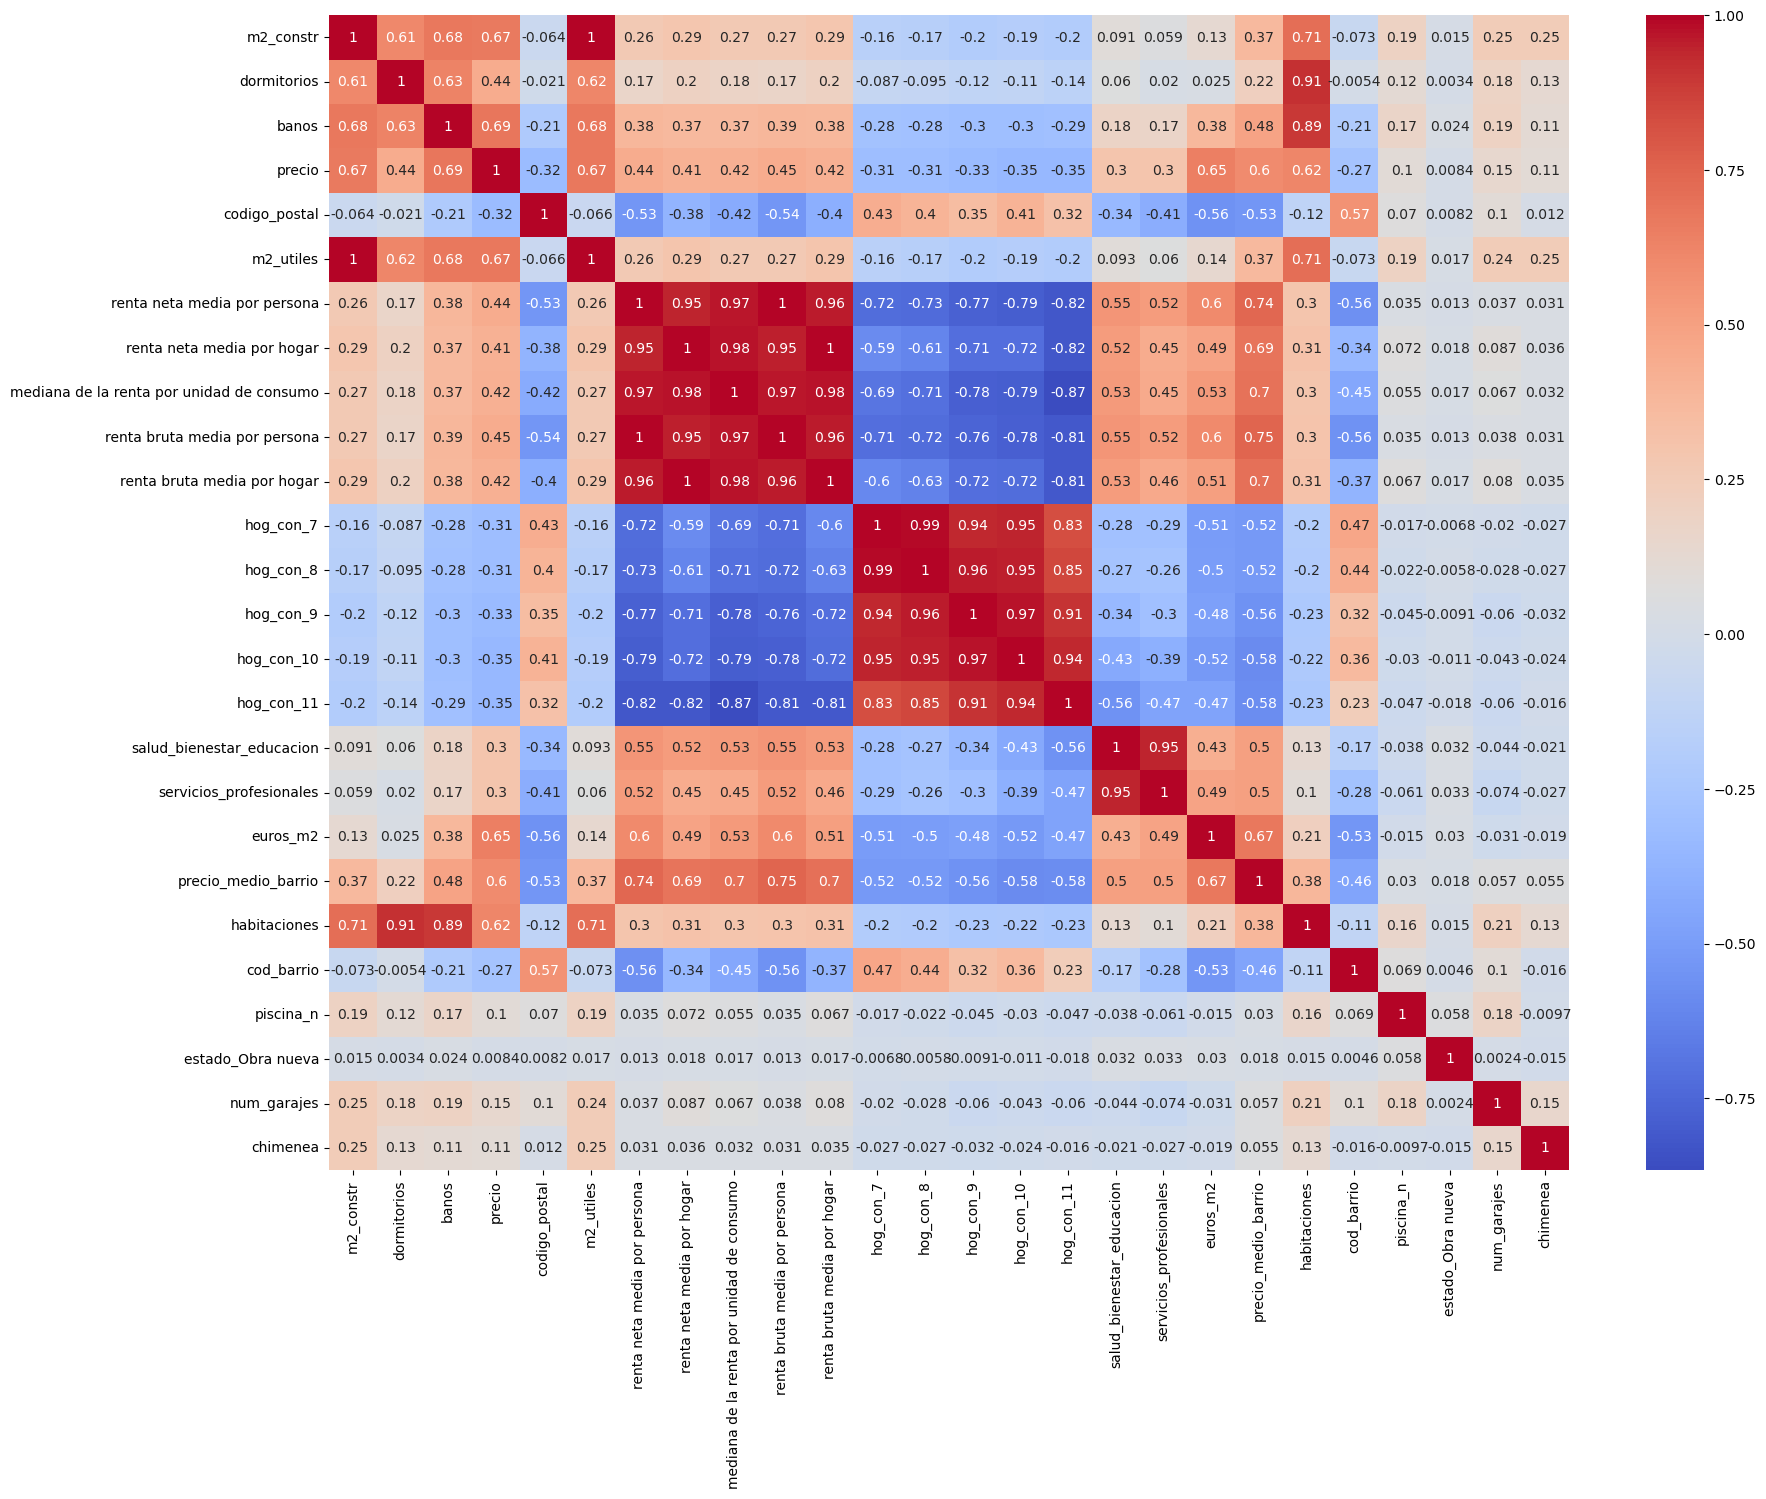

In [284]:
corr_matrix = dfb[columnas_seleccionadas].corr()
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()


In [285]:
columnas_seleccionadas.extend(["url"])  # .extend() modifica la lista directamente
#creo el dataframe para rear el modelo
df=dfb[columnas_seleccionadas]

In [286]:
#Modelo baseline 1
#cols=['url','salud_bienestar_educacion','precio_medio_barrio','euros_m2','renta bruta media por persona','total_estaciones','m2_constr', 'dormitorios', 'balcon', 'terraza', 'trastero', 'ascensor','cod_barrio', 'banos', 'precio', 'tiene_armario','tiene_jardin','tiene_piscina','total_transacciones','renta neta media por hogar','cultura_entretenimiento']
#df=dfb[cols]


In [287]:
print(f"El DataFrame dfEDA tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

El DataFrame dfEDA tiene 10009 filas y 27 columnas.


In [288]:
# Supongamos que df es tu DataFrame original
dfcorr = df.drop(columns=['url'])

# Ahora puedes trabajar con dfcorr
print(dfcorr.head())


   m2_constr  dormitorios  banos   precio  codigo_postal  m2_utiles  \
0     100.00            1      1  2000000          28001      80.00   
1      74.00            1      1   650000          28016      59.20   
2      76.00            1      1   650000          28016      60.80   
3      80.00            2      1   599999          28016      64.00   
4      76.00            1      1   625000          28016      60.80   

   renta neta media por persona  renta neta media por hogar  \
0                         28.14                       64.92   
1                         30.51                       74.84   
2                         30.51                       74.84   
3                         30.51                       74.84   
4                         30.51                       74.84   

   mediana de la renta por unidad de consumo  renta bruta media por persona  \
0                                      31.15                          38.75   
1                                   

In [289]:
# Plotting the heatmap of correlation between features
#plt.figure(figsize=(20,20))
#sns.heatmap(dfcorr, cbar=True, square=True, fmt='.1f', cmap='Greens')

#plt.show()


In [290]:
### 2.3 Partición en train / test

In [291]:
df.precio.describe(percentiles=[0.15,0.3,0.45,0.55,0.75,0.9])

count      10009.00
mean      890233.84
std      1160033.59
min        54000.00
15%       185000.00
30%       269000.00
45%       408000.00
50%       480000.00
55%       580000.00
75%      1090000.00
90%      1995000.00
max     19950000.00
Name: precio, dtype: float64

In [292]:
# Guardamos la  variable target en una variable "target"
target = 'precio'
df[target].head()

0    2000000
1     650000
2     650000
3     599999
4     625000
Name: precio, dtype: int64

In [293]:
dfbaseline=df
# Dividir las columnas objetivo y características, preservando nombres de columnas
y = dfbaseline[target].values
X = dfbaseline.drop(columns=[target, 'url'])
df_ids = dfbaseline[['url']]

# Primera clasificación entre train y test
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, df_ids, test_size=0.2, random_state=42)

#Segunda división: Train y Validación a partir de X_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Número de registros del dataset de train y de test
print("Número de observaciones")
print("- Train: ", X_train.shape[0])
print("- Test:  ", X_test.shape[0])
print("- Val:  ", X_val.shape[0])

dftrain = X_train.reset_index(drop=True)
dftest = X_test.reset_index(drop=True)
dfval = X_val.reset_index(drop=True)



Número de observaciones
- Train:  6405
- Test:   2002
- Val:   1602


In [294]:
## 3. Regresión Lineal

### 3.1 Entrenamiento del modelo

In [295]:
# Import library for Linear Regression
#from sklearn.linear_model import LinearRegression

# Create a Linear regressor
lm = LinearRegression()

# Train the model using the training sets
lm.fit(X_train, y_train)

LinearRegression()

In [296]:
# Converting the coefficient values to a dataframe
coeffcients = pd.DataFrame([X_train.columns, lm.coef_]).T
coeffcients = coeffcients.rename(columns={0: 'Attribute', 1: 'Coefficients'})
coeffcients

,Attribute,Coefficients
0,m2_constr,1446.35
1,dormitorios,-11948.69
2,banos,46304.28
3,codigo_postal,788.12
4,m2_utiles,4041.14
5,renta neta media por persona,-403151.61
6,renta neta media por hogar,90650.28
7,mediana de la renta por unidad de consumo,52161.44
8,renta bruta media por persona,309602.88
9,renta bruta media por hogar,-95523.53


La variable precio_medio_barrio tiene un valor cercano a 0 por lo que no tiene impacto en modelo
La variable renta neta media por persona tiene una relación negativa con la variable target. Al aumentar esta variable, la predicción disminuye.Lo cual no tiene mucho sentido. endriamos que ver como se ha calculado esa renta neta, ya que pasa al contrario con la renta renta bruta media por persona

### 3.2 Evaluación sobre train

In [297]:
# Model prediction on train df
y_pred = lm.predict(X_train)

In [298]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_train, y_pred))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

R^2: 0.8237782686893167
MAE: 246938.90618818658
MSE: 232362635173.82886
RMSE: 482040.07631505997


- **𝑅^2**: Es una medida de la relación lineal entre X e Y. Se interpreta como la proporción de la varianza en la variable dependiente que es predecible a partir de la variable independiente.

- **MAE**: Es la media del valor absoluto de los errores. Mide la diferencia entre dos variables continuas, en este caso, los valores reales y los valores predichos de y.

- **MSE**: El error cuadrático medio (MSE, por sus siglas en inglés) es similar al MAE, pero eleva al cuadrado la diferencia antes de sumarlas todas, en lugar de usar el valor absoluto.

- **RMSE**: La raíz cuadrada del error cuadrático medio (RMSE, por sus siglas en inglés) es la raíz cuadrada del MSE.

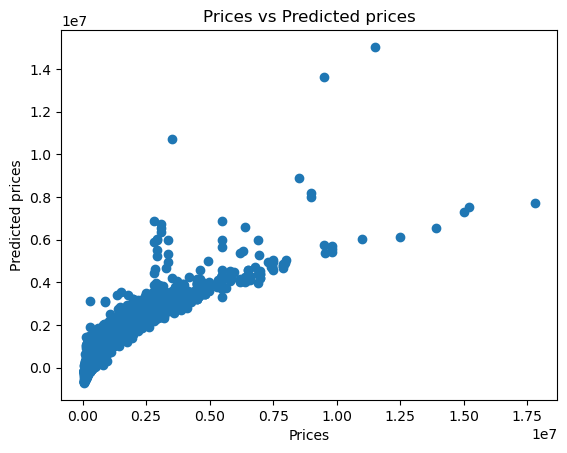

In [299]:
# Visualizing the differences between actual prices and predicted values
plt.scatter(y_train, y_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs Predicted prices")
plt.show()

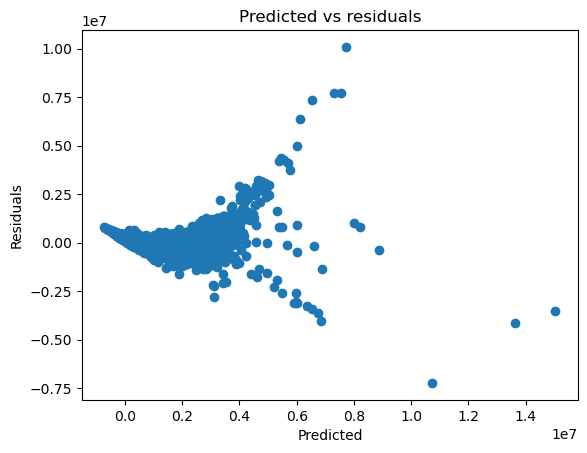

In [300]:
# Checking residuals
plt.scatter(y_pred,y_train-y_pred)
plt.title("Predicted vs residuals")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

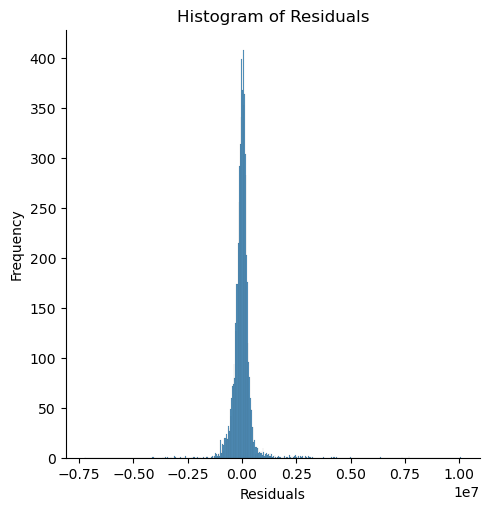

In [301]:
# Checking Normality of errors
sns.displot(y_train-y_pred)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

In [302]:


# Calcular errores (diferencias absolutas entre y_train y y_pred)
errores = pd.Series(np.abs(y_train - y_pred), index=X_train.index)

# Establecer el umbral para identificar outliers (e.g., 2 desviaciones estándar)
umbral = errores.mean() + 2 * errores.std()

# Identificar índices de los outliers
outliers_indices = errores[errores > umbral].index

# Extraer IDs de las observaciones consideradas como outliers
outliers_ids = ids_train.loc[outliers_indices]

# Mostrar los IDs de los outliers
print("IDs de los outliers:")
print(outliers_ids)

# (Opcional) Extraer también las características de los outliers
outliers_X = X_train.loc[outliers_indices]
print("Características de los outliers:")
print(outliers_X)


IDs de los outliers:
                                                                                                                           url
356                                                                                  https://www.indomio.es/anuncios/95022863/
889                                                                                  https://www.indomio.es/anuncios/96074845/
3690                                               https://www.pisos.com/comprar/piso-justicia_chueca28046-37595993029_102100/
4253                                                     https://www.pisos.com/comprar/piso-recoletos28001-44190825878_101800/
264                                                                                  https://www.indomio.es/anuncios/94463387/
5325                                          https://www.pisos.com/comprar/piso-salamanca_castellana28006-40074691500_101800/
507                                                                                  https

### 3.3 Evaluación sobre validación

In [303]:
# Model prediction on train df
y_pred_val = lm.predict(X_val)

In [304]:
# Model Evaluation
print('R^2:',metrics.r2_score(y_val, y_pred_val))
print('MAE:',metrics.mean_absolute_error(y_val, y_pred_val))
print('MSE:',metrics.mean_squared_error(y_val, y_pred_val))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_val, y_pred_val)))

R^2: 0.611749240331622
MAE: 266165.9322974572
MSE: 509528504789.68445
RMSE: 713812.6538453101


In [206]:

# Calcular errores (diferencias absolutas entre y_train y y_pred)
errores = pd.Series(np.abs(y_val - y_pred_val), index=X_val.index)

# Establecer el umbral para identificar outliers (e.g., 2 desviaciones estándar)
umbral = errores.mean() + 2 * errores.std()

# Identificar índices de los outliers
outliers_indices = errores[errores > umbral].index

# Extraer IDs de las observaciones consideradas como outliers
outliers_ids = ids_train.loc[outliers_indices]

# Mostrar los IDs de los outliers
print("IDs de los outliers:")
print(outliers_ids)

# (Opcional) Extraer también las características de los outliers
outliers_X = X_val.loc[outliers_indices]
print("Características de los outliers:")
print(outliers_X)

IDs de los outliers:
                                                                                             url
499                                                    https://www.indomio.es/anuncios/95469219/
492                                                    https://www.indomio.es/anuncios/95463509/
1464                                                   https://www.indomio.es/anuncios/96517461/
1961                                                   https://www.indomio.es/anuncios/96670987/
4928            https://www.pisos.com/comprar/piso-salamanca_castellana28006-34232013494_108900/
1641                                                   https://www.indomio.es/anuncios/96571765/
3283          https://www.pisos.com/comprar/chalet-moncloa_aravaca_el_plantio-4197366832_107000/
899                                                    https://www.indomio.es/anuncios/96084671/
6033                https://www.pisos.com/comprar/piso-chamberi_almagro28046-41671369528_109300/
1571     

### 3.4 Evaluación sobre test

In [210]:
# Print the rows with infinite values
# Check for infinite values in X_test
inf_rows = np.where(np.isinf(X_test).any(axis=1))[0]

# Print the rows with infinite values
print("Rows with infinite values:")
print(X_test.iloc[inf_rows])

# Check for large values in X_test exceeding float64 limits
large_rows = np.where(np.abs(X_test) > np.finfo(np.float64).max)[0]

# Print the rows with large values
print("\nRows with large values:")
print(X_test.iloc[large_rows])



Rows with infinite values:
Empty DataFrame
Columns: [m2_constr, dormitorios, banos, codigo_postal, m2_utiles, renta neta media por persona, renta neta media por hogar, mediana de la renta por unidad de consumo, renta bruta media por persona, renta bruta media por hogar, hog_con_7, hog_con_8, hog_con_9, hog_con_10, hog_con_11, salud_bienestar_educacion, servicios_profesionales, euros_m2, precio_medio_barrio, habitaciones, cod_barrio, piscina_n, estado_Obra nueva]
Index: []

Rows with large values:
Empty DataFrame
Columns: [m2_constr, dormitorios, banos, codigo_postal, m2_utiles, renta neta media por persona, renta neta media por hogar, mediana de la renta por unidad de consumo, renta bruta media por persona, renta bruta media por hogar, hog_con_7, hog_con_8, hog_con_9, hog_con_10, hog_con_11, salud_bienestar_educacion, servicios_profesionales, euros_m2, precio_medio_barrio, habitaciones, cod_barrio, piscina_n, estado_Obra nueva]
Index: []


In [211]:
# Predicting Test df with the model
y_test_pred = lm.predict(X_test)

In [212]:
# Model Evaluation
acc_linreg = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_linreg)
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.8109668416582488
MAE: 252293.517821321
MSE: 275592506197.3297
RMSE: 524969.0526091321


# **_4. Exploración de datos_**

## 4.1 Tipo de datos

In [370]:
# Función `columnas_por_tipo` que muestra un resumen de los tipo de columnas que hay en el dataframe
# boolean_columns, numeric_cols, cat_columns, object_columns, other_columns
cols_bool, cols_num, cols_cat, cols_obj, cols_other = columnas_por_tipo(df)
print("Booleans:", cols_bool)
print("Numéricas:", cols_num)
print("Categóricas:", cols_cat)
print("Objeto:", cols_obj)
print("Otras:", cols_other)

Número de columnas de tipo entero: 14
Columnas de tipo entero: ['salud_bienestar_educacion', 'total_estaciones', 'dormitorios', 'balcon', 'terraza', 'trastero', 'ascensor', 'cod_barrio', 'banos', 'precio', 'tiene_armario', 'tiene_jardin', 'tiene_piscina', 'cultura_entretenimiento']
Número de columnas de tipo float: 6
Columnas de tipo float: ['precio_medio_barrio', 'euros_m2', 'renta bruta media por persona', 'm2_constr', 'total_transacciones', 'renta neta media por hogar']
Número de columnas de tipo object: 1
Columnas de tipo object: ['url']
Número de columnas de tipo category: 0
Columnas de tipo category: []
Número de columnas de otros tipos: 0
Columnas de otros tipos: []
Booleans: ['balcon', 'terraza', 'trastero', 'ascensor', 'tiene_armario', 'tiene_jardin', 'tiene_piscina']
Numéricas: ['salud_bienestar_educacion', 'total_estaciones', 'dormitorios', 'balcon', 'terraza', 'trastero', 'ascensor', 'cod_barrio', 'banos', 'precio', 'tiene_armario', 'tiene_jardin', 'tiene_piscina', 'cultura

# Modelos

In [371]:
dfModelo=df

In [372]:
dfModelo.columns.tolist()

['url',
 'salud_bienestar_educacion',
 'precio_medio_barrio',
 'euros_m2',
 'renta bruta media por persona',
 'total_estaciones',
 'm2_constr',
 'dormitorios',
 'balcon',
 'terraza',
 'trastero',
 'ascensor',
 'cod_barrio',
 'banos',
 'precio',
 'tiene_armario',
 'tiene_jardin',
 'tiene_piscina',
 'total_transacciones',
 'renta neta media por hogar',
 'cultura_entretenimiento']

In [373]:
dfModelo.isnull().sum()

,0
url,0
salud_bienestar_educacion,0
precio_medio_barrio,0
euros_m2,0
renta bruta media por persona,0
total_estaciones,0
m2_constr,0
dormitorios,0
balcon,0
terraza,0


In [374]:
# Dividir las columnas objetivo y características, preservando nombres de columnas
y = dfModelo[target].values
X = dfModelo.drop(columns=[target,'url'])

df_ids = dfModelo[['url']]

# Primera clasificación entre train y test
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, df_ids, test_size=0.2, random_state=42)
# Número de registros en cada conjunto
print("Número de observaciones")
print("- Train:      ", X_train.shape[0])
print("- Test:       ", X_test.shape[0])

Número de observaciones
- Train:       8007
- Test:        2002


In [375]:
X_train.head()

,salud_bienestar_educacion,precio_medio_barrio,euros_m2,renta bruta media por persona,total_estaciones,m2_constr,dormitorios,balcon,terraza,trastero,ascensor,cod_barrio,banos,tiene_armario,tiene_jardin,tiene_piscina,total_transacciones,renta neta media por hogar,cultura_entretenimiento
8292,375,686827.15,6192.66,22.89,178,109.00,2,0,0,1,1,62,2,0,0,0,416.00,42.47,538
8494,237,271790.91,2636.36,20.09,163,110.00,4,0,0,1,1,141,2,0,0,0,58.00,40.32,321
1095,45,172899.14,1705.88,13.60,202,170.00,3,0,0,0,1,174,2,0,0,1,336.00,32.53,54
4328,596,374364.29,5251.14,29.05,341,219.00,4,0,0,0,0,164,4,0,0,0,448.00,57.51,486
8966,137,1365557.41,4583.33,27.03,210,60.00,3,0,0,0,0,14,1,0,0,0,323.00,41.06,259


In [376]:
y_train

array([ 675000,  290000,  290000, ...,  159000,  595000, 1290000])

In [381]:

 from scipy.stats import randint, uniform


regressors = {
     'LinearRegression': {
        'model': LinearRegression(),
        'hyperparameters': {}  # No hyperparameters for basic Linear Regression
    },
    'Ridge': {
        'model': Ridge(),
        'hyperparameters': {
            'alpha': uniform(0.01, 10)  # Explore alpha values for L2 regularization
        }
    },
    'Lasso': {
        'model': Lasso(),
        'hyperparameters': {
            'alpha': uniform(0.01, 10)  # Explore alpha values for L1 regularization
        }
    },
    'XGBoost': {
        'model': XGBRegressor(objective='reg:squarederror', n_jobs=-1),
        'hyperparameters': {
            'max_depth': randint(3, 12),  # Increased max_depth range
            'n_estimators': randint(100, 500),  # Increased n_estimators range
            'learning_rate': [0.001, 0.01, 0.1, 0.2], # Wider range, including smaller values
            'subsample': uniform(0.5, 0.5),  # Changed to uniform distribution, focused on 0.5-1.0
            'colsample_bytree': uniform(0.5, 0.5), # Added colsample_bytree for feature subsampling
            'reg_alpha': [0, 0.1, 1],  # Added L1 regularization
            'reg_lambda': [0, 0.1, 1]  # Added L2 regularization
        }
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(),
        'hyperparameters': {
            'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"], # Added criteria
            'max_depth': randint(5, 15),  # Increased max_depth range
            'min_samples_leaf': randint(2, 10),  # Increased min_samples_leaf range
            'min_samples_split': randint(2, 10) # Added min_samples_split for splitting control
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(n_jobs=-1),
        'hyperparameters': {
            'max_depth': randint(5,15),  # Increased max_depth range
            'min_samples_leaf': randint(2, 10),  # Increased min_samples_leaf range
            'n_estimators': randint(50, 200),  # Increased n_estimators range
            'max_features': ['auto', 'sqrt', 'log2'] # Added max_features for feature selection
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(),
        'hyperparameters': {
            'max_depth': randint(3, 15),  # Increased max_depth range
            'min_samples_leaf': randint(2, 10),  # Increased min_samples_leaf range
            'learning_rate': [0.001, 0.01, 0.1], # Adjusted learning rates
            'n_estimators': randint(50, 200),  # Increased n_estimators range
            'subsample': uniform(0.5, 0.5) # Added subsample for row subsampling
        }
    },
    'CatBoost': {
        'model': CatBoostRegressor(verbose=0),
        'hyperparameters': {
            'depth': randint(4, 12),  # Increased depth range
            'learning_rate': [0.001, 0.01, 0.1], # Adjusted learning rates
            'iterations': randint(50, 200),  # Increased iterations range
            'l2_leaf_reg': [1, 3, 5, 7, 9] # Added l2_leaf_reg for regularization
        }
    }
}

# Entrenamiento

In [382]:
random_search_output = list()
best_estimators = {}

for reg_name, reg_info in regressors.items():
    print(reg_name)

    reg_random_search = RandomizedSearchCV(
        estimator=reg_info['model'],
        param_distributions=reg_info['hyperparameters'],
        n_iter=20,
        cv=5,
        scoring="neg_mean_squared_error",  # Métrico adecuado para regresión
        return_train_score=True,
        refit=True,
        n_jobs=-1,
        verbose=1,
        error_score='raise'
    )
    reg_random_search.fit(X_train, y_train)

    # Resultados del Random Search
    df_output = pd.DataFrame(reg_random_search.cv_results_)
    df_output['regressor'] = reg_name
    random_search_output.append(df_output)

    # Modelo re-entrenado con los hiperparámetros óptimos
    best_estimators[reg_name] = reg_random_search.best_estimator_


LinearRegression
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning:

The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.



Ridge
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Lasso
Fitting 5 folds for each of 20 candidates, totalling 100 fits
XGBoost
Fitting 5 folds for each of 20 candidates, totalling 100 fits
DecisionTree
Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomForest
Fitting 5 folds for each of 20 candidates, totalling 100 fits


InvalidParameterError: The 'max_features' parameter of RandomForestRegressor must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.

In [383]:
# Concatenamos todos los resultados para cada modelo
df_results = pd.concat(random_search_output).reset_index(drop=True)

# Columnas de resultados del cross-validation para regresión
split_test_score_columns = ['split0_test_score', 'split1_test_score', 'split2_test_score']

# Ajustamos las columnas para reflejar los datos de regresión
df_results = df_results[
    ['regressor', 'rank_test_score', 'mean_train_score', 'mean_test_score', 'std_test_score', 'params']
    + split_test_score_columns
]

# Mostramos una muestra aleatoria de 20 resultados
df_results.sample(20)


,regressor,rank_test_score,mean_train_score,mean_test_score,std_test_score,params,split0_test_score,split1_test_score,split2_test_score
32,Lasso,8,-280918075924.95,-296238436058.08,90080216591.53,{'alpha': 4.495026139356499},-244376194755.16,-223463132243.52,-317049849914.76
20,Ridge,4,-280918213788.12,-296232384531.15,90106186738.57,{'alpha': 8.197302439362135},-244376919422.47,-223433364747.54,-317040425533.31
45,XGBoost,7,-4758268211.20,-60700311961.60,27568300674.94,"{'colsample_bytree': 0.9394314711987042, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 301, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8769459912893693}",-67535634432.00,-71984717824.00,-29769740288.00
19,Ridge,7,-280918193776.59,-296232862455.00,90104098545.78,{'alpha': 7.579556409104877},-244376901026.45,-223435730548.13,-317041221717.53
64,DecisionTree,1,-16696229083.08,-41227263561.34,22624015954.79,"{'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 6}",-56948349816.09,-72311854790.76,-18564541530.48
50,XGBoost,4,-1411938048.00,-51353222348.80,20919579735.11,"{'colsample_bytree': 0.6162385676004642, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 316, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.630249971852571}",-58330013696.00,-58590375936.00,-20812275712.00
24,Lasso,10,-280918075636.87,-296238486189.63,90080026540.23,{'alpha': 4.015194049822753},-244376267336.34,-223463332422.06,-317049997953.00
14,Ridge,9,-280918143872.80,-296234277510.93,90097968017.69,{'alpha': 5.766834420824609},-244376861075.75,-223442690357.63,-317043575331.94
51,XGBoost,10,-39286780.00,-72026282393.60,18165704953.17,"{'colsample_bytree': 0.7149218075977353, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 393, 'reg_alpha': 1, 'reg_lambda': 0.1, 'subsample': 0.8782583746365955}",-84720189440.00,-72487084032.00,-75730173952.00
58,XGBoost,14,-31138961817.60,-151380282572.80,25414603528.93,"{'colsample_bytree': 0.5632535218043923, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 237, 'reg_alpha': 1, 'reg_lambda': 0.1, 'subsample': 0.8451655904598881}",-137383116800.00,-152320065536.00,-144804757504.00


In [384]:
# Nos quedamos con el mejor modelo de cada tipo para regresión
df_best = (
    df_results
    .query('rank_test_score == 1')  # Mantiene los modelos con el mejor ranking
    .drop_duplicates(['regressor', 'rank_test_score'])  # Reemplaza 'clf' por 'regressor'
    .sort_values('mean_test_score', ascending=False)  # Ordenamos por el score promedio
    .reset_index(drop=True)  # Reiniciamos el índice
)
df_best


,regressor,rank_test_score,mean_train_score,mean_test_score,std_test_score,params,split0_test_score,split1_test_score,split2_test_score
0,DecisionTree,1,-16696229083.08,-41227263561.34,22624015954.79,"{'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 6}",-56948349816.09,-72311854790.76,-18564541530.48
1,XGBoost,1,-38067830.40,-43371299840.00,26351333684.58,"{'colsample_bytree': 0.9798090253196625, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 297, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.6561625898014602}",-61595951104.00,-53292249088.00,-7132996608.00
2,Ridge,1,-280918222048.07,-296232197744.25,90107005321.71,{'alpha': 8.439503079251242},-244376927294.19,-223432438010.93,-317040114183.63
3,Lasso,1,-280918081007.48,-296237904199.46,90082240482.81,{'alpha': 9.604527852747458},-244375423769.88,-223461002788.70,-317048275456.13
4,LinearRegression,1,-280918074499.48,-296238906930.07,90078436286.82,{},-244376875888.26,-223465008858.03,-317051237943.78


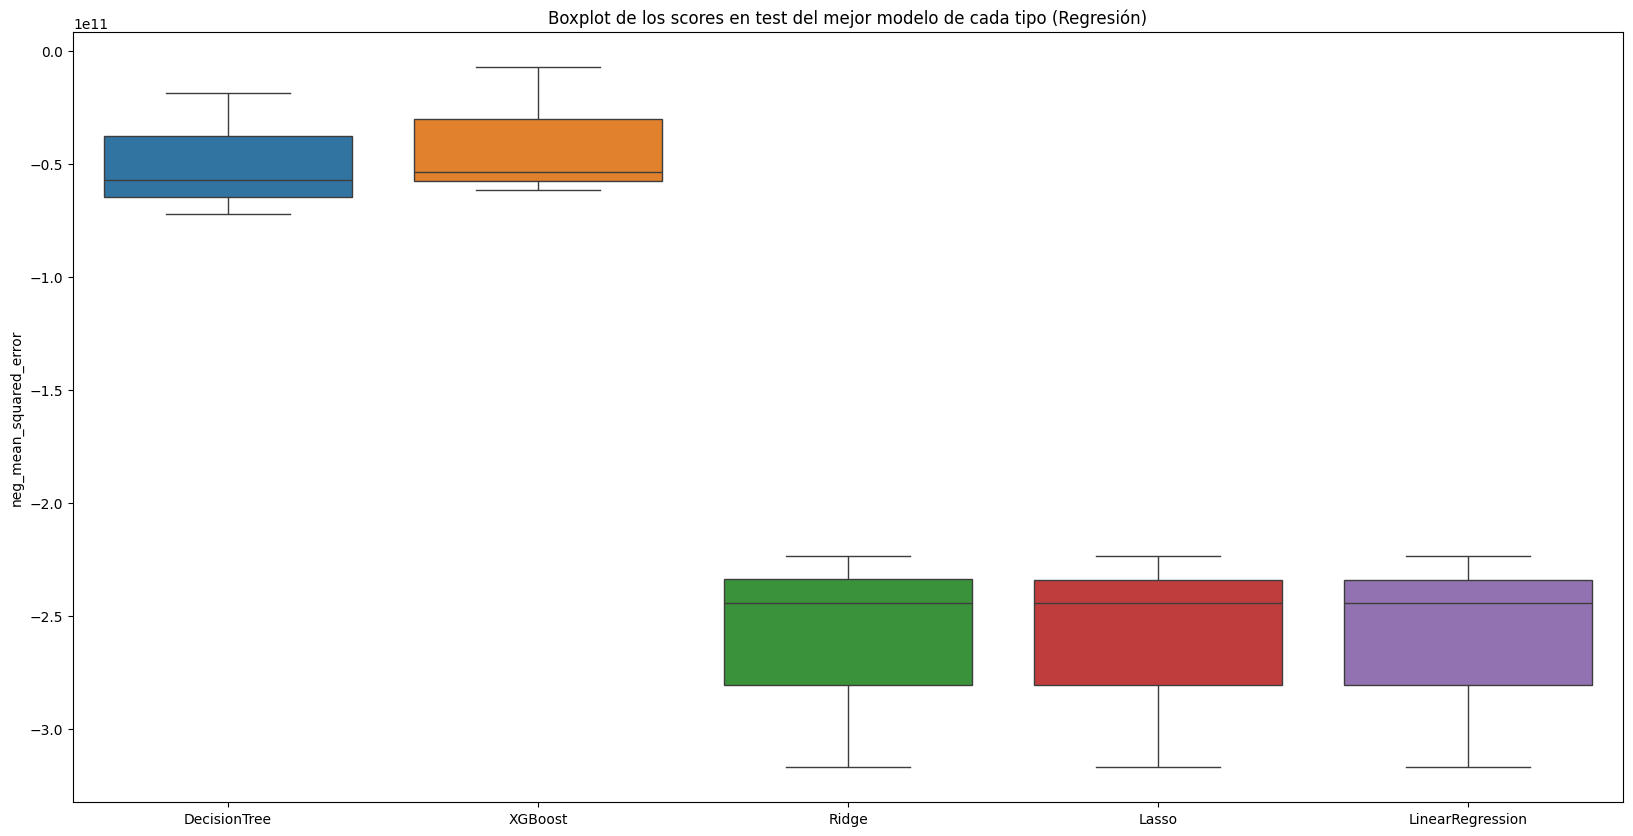

In [385]:
# Transponer el DataFrame para que cada modelo sea una columna
df_transposed = df_best[split_test_score_columns].T

# Crear el boxplot usando Seaborn
plt.figure(figsize=(20, 10))
sns.boxplot(data=df_transposed)
plt.ylabel("neg_mean_squared_error")  # Cambiado para reflejar la métrica de regresión

plt.title("Boxplot de los scores en test del mejor modelo de cada tipo (Regresión)")
# Añadir etiquetas al eje x
plt.xticks(ticks=range(len(df_transposed.columns)), labels=df_best["regressor"])  # Cambiar 'clf' por 'regressor'
plt.show()


In [386]:
for i, r in df_best.iterrows():
    print(r.regressor, "=>", np.round(r.mean_test_score, 4), "\u00B1", np.round(r.std_test_score, 4))


DecisionTree => -41227263561.3432 ± 22624015954.7893
XGBoost => -43371299840.0 ± 26351333684.5779
Ridge => -296232197744.255 ± 90107005321.7101
Lasso => -296237904199.458 ± 90082240482.8136
LinearRegression => -296238906930.071 ± 90078436286.8184


In [387]:
    # Escogemos el mejor modelo de todos
best_model= best_estimators['GradientBoosting']

KeyError: 'GradientBoosting'

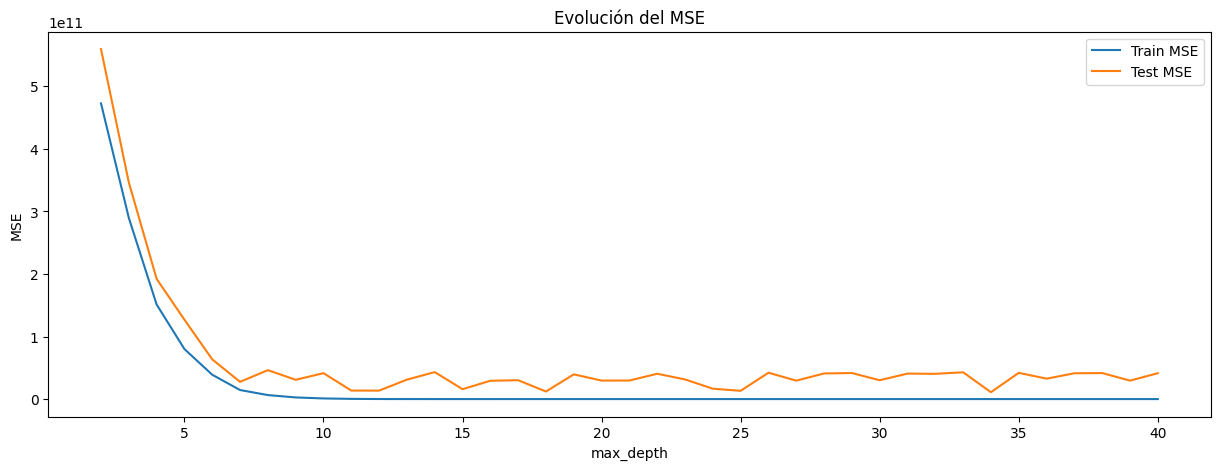

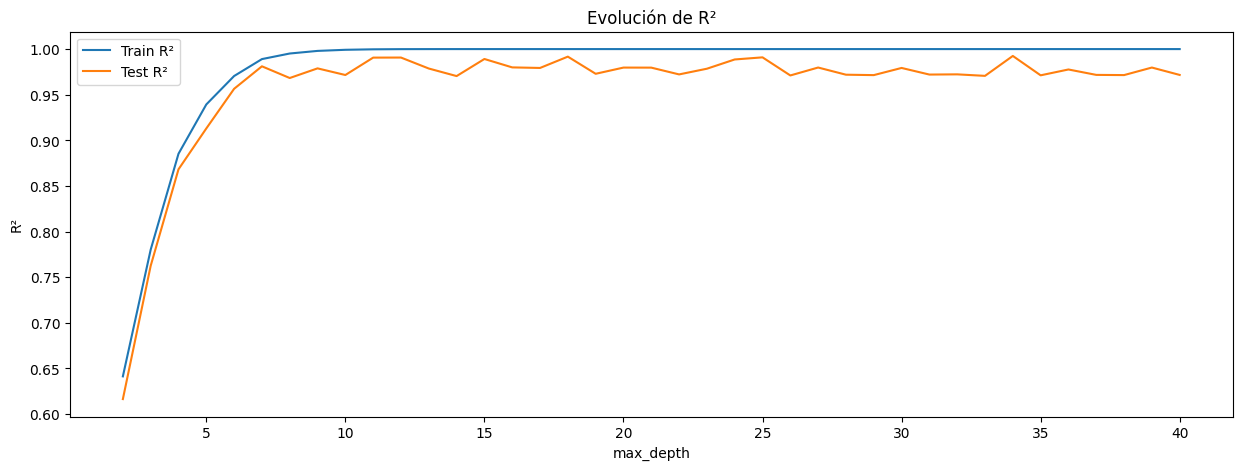

In [388]:
from sklearn.metrics import mean_squared_error, r2_score

# Definir rango para max_depth
max_max_depth = 41
l_mse_train = list()
l_mse_test = list()
l_r2_train = list()
l_r2_test = list()

for i in range(2, max_max_depth):
    # Entrenar modelo
    reg = DecisionTreeRegressor(max_depth=i)
    reg.fit(X_train, y_train)

    # Métricas para el conjunto de entrenamiento
    y_pred_train = reg.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    l_mse_train.append(mse_train)
    l_r2_train.append(r2_train)

    # Métricas para el conjunto de prueba
    y_pred_test = reg.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    l_mse_test.append(mse_test)
    l_r2_test.append(r2_test)

# Graficar evolución del MSE
plt.figure(figsize=(15, 5))
plt.plot(range(2, max_max_depth), l_mse_train, label='Train MSE')
plt.plot(range(2, max_max_depth), l_mse_test, label='Test MSE')
plt.title("Evolución del MSE")
plt.xlabel("max_depth")
plt.ylabel("MSE")
plt.legend()
plt.show()

# Graficar evolución de R²
plt.figure(figsize=(15, 5))
plt.plot(range(2, max_max_depth), l_r2_train, label='Train R²')
plt.plot(range(2, max_max_depth), l_r2_test, label='Test R²')
plt.title("Evolución de R²")
plt.xlabel("max_depth")
plt.ylabel("R²")
plt.legend()
plt.show()


Gráfico de predicciones frente a valores reales: Esto muestra cómo las predicciones del modelo se alinean con los valores reales (idealmente, deberían seguir una línea diagonal).

ValueError: x and y must be the same size

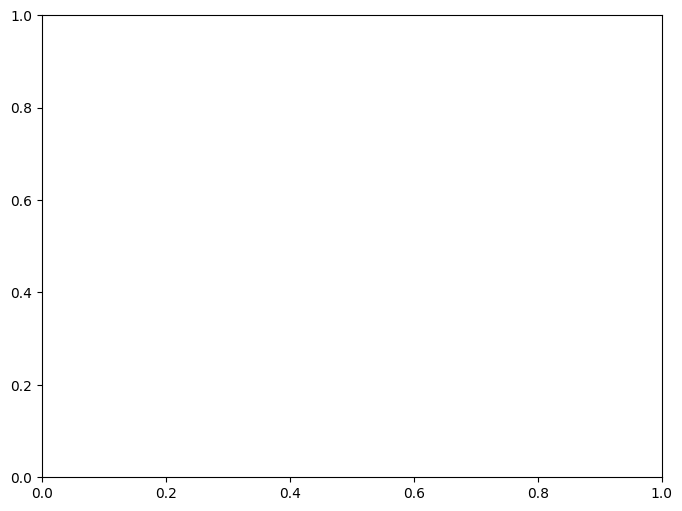

In [389]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Gráfico de predicciones vs valores reales")
plt.show()


Error residual: Graficar los residuos (diferencia entre valores reales y predichos) para identificar patrones que sugieran falta de calibración.

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.6)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Gráfico de residuos")
plt.show()


Gráfico de distribuciones: Verificar si la distribución de los errores es aproximadamente normal.

In [ ]:
sns.histplot(y_test - y_pred, kde=True, bins=30)
plt.title("Distribución de los errores (residuos)")
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.show()


Métricas clave de error: Calcular métricas como MAE (Mean Absolute Error), MSE (Mean Squared Error) o RMSE (Root Mean Squared Error) para evaluar el desempeño.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


In [ ]:
# Obtener la importancia de las características
importances = best_model_2.feature_importances_

# Ordenar las características por importancia
indices = np.argsort(importances)[::-1]

# Seleccionar las 10 características más importantes
top_n = 10
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_features = X_train.columns[top_indices]

# Crear el gráfico de barras horizontal
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_importances, align="center")
plt.yticks(range(top_n), top_features)
plt.xlabel("Importancia")
plt.title("Importancia de las 10 características más importantes")
plt.gca().invert_yaxis()  # Invertir el eje y para que la característica más importante esté arriba
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predicciones
y_pred = best_model_2.predict(X_test)

# Métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

# Visualización: valores reales vs predicciones
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label="Valores predichos")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label="Línea ideal")
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Valores reales vs. Predicciones")
plt.legend()
plt.show()

# Visualización: residuos
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.6)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicciones")
plt.ylabel("Residuos")
plt.title("Gráfico de Residuos")
plt.show()



¡Sí! **SHAP** (SHapley Additive exPlanations) también es válido y muy útil para modelos de regresión. El proceso sigue siendo prácticamente el mismo que para clasificación, pero con algunos ajustes en la interpretación:

1. **Salidas SHAP en regresión**:
   - En lugar de explicar probabilidades o clasificaciones, los valores SHAP explicarán las **predicciones continuas** del modelo, como la cantidad en euros o cualquier métrica de tu variable objetivo.

2. **Predicción en regresión**:
   - En vez de `output_margin=True` (que se usa para trabajar en la escala de logits en clasificación), puedes simplemente usar las predicciones directas del modelo (`y_pred = best_model.predict(X_train)`) y comparar los valores SHAP con esas predicciones continuas.

3. **Interpretación de las contribuciones**:
   - Los valores SHAP muestran cómo cada característica contribuye a aumentar o disminuir el valor predicho para cada muestra. Esto te ayuda a entender, por ejemplo, si una característica aumenta el precio de una vivienda o si lo reduce, y en qué magnitud.

4. **Visualización en regresión**:
   Puedes usar las mismas visualizaciones que con clasificación:
   - Resumen global:
     ```python
     shap.summary_plot(shap_values.values, X_train)
     ```
   - Dependencia parcial:
     ```python
     shap.dependence_plot("feature_name", shap_values.values, X_train)
     ```
   - Fuerza individual (para una muestra específica):
     ```python
     shap.force_plot(explainer.expected_value, shap_values.values[0], X_train.iloc[0])
     ```

### Validación del código:
El siguiente fragmento sigue siendo válido para regresión, solo ajustando cómo obtienes las predicciones para comparación:
```python
explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_train)  # Obtención de valores SHAP
y_pred_raw = best_model.predict(X_train)  # Predicciones directas del modelo
# Validar que los SHAP values sumen las predicciones
np.abs(shap_values.values.sum(axis=1) + shap_values.base_values - y_pred_raw).max()
```

Si `np.abs(...).max()` devuelve `0.0` o un valor cercano a cero, los valores SHAP están correctamente calculados.

### En resumen:
**SHAP es completamente válido y poderoso para regresión.** Te ofrece la capacidad de entender qué características tienen mayor impacto en las predicciones continuas del modelo. Si necesitas ayuda para personalizar visualizaciones o análisis, estoy lista para ayudarte 😊.

Enviar un mensaje a Copilot